In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os, sys
sys.path.append(os.path.abspath('..'))

In [4]:
from btdsa.config import Config, BASELINE_MODEL_FAMILY, TDSA_MODEL_LIST
from btdsa.eval_utils import EvalSurv
from btdsa.train_utils import init_trainer
from btdsa.utils import create_logger
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from pycox.models import utils
import pandas as pd

In [5]:
def setup_model_config(model_name, time_range='full', experiment_root='../experiments'):
    cfg = Config
    cfg.model_name = model_name
    cfg.time_range = time_range
    cfg.random_state = 1234 # will be repeated across multiple random_state variables
    cfg.model_save_dir = Path(experiment_root) / cfg.model_save_dir
    cfg.setup()
    return cfg

def infer_surv(model_name, dataset, group='uncensor',
               time_range='full', experiment_root='../experiments'):
    cfg = setup_model_config(model_name, time_range, experiment_root=experiment_root)
    weight_file = cfg.model_save_dir / f"{cfg.model_name}_{cfg.time_range}_L{cfg.seq_len}_{dataset}.pth"
    trainer = init_trainer(cfg)
    model = trainer.load_model(weight_file)
    x_test, y_test = trainer.test
    
    assert group in ['uncensor', 'censor']
    if group == 'uncensor':
        v = 1
    else:
        v = 0
        
    durations, events = y_test.T
    idxs = np.where(events==v)
    x_test = x_test[idxs]
    durations_test = durations[idxs]
    
    print(model.duration_index)
                
    if trainer.interpolate_discrete_times:
        surv = model.interpolate(100).predict_surv(x_test)
        duration_index = model.duration_index[:-1]
        index = utils.make_subgrid(duration_index, 100)
        surv = pd.DataFrame(surv.transpose()[:len(index)], index)
    else:
        if hasattr(model, 'compute_baseline_hazards'):
            _ = model.compute_baseline_hazards()
        surv = model.predict_surv_df(x_test)

    return surv, durations_test

In [6]:
dataset = 'support'
time_range = 'full'
model_list = ['DeepHitSingle', 'BTDSA']

## Survival Functions

[   0.        106.789474  213.57895   320.3684    427.1579    533.9474
  640.7368    747.5263    854.3158    961.1053   1067.8948   1174.6842
 1281.4736   1388.2632   1495.0526   1601.8422   1708.6316   1815.421
 1922.2106   2029.      ]
[   0.          106.78947368  213.57894737  320.36842105  427.15789474
  533.94736842  640.73684211  747.52631579  854.31578947  961.10526316
 1067.89473684 1174.68421053 1281.47368421 1388.26315789 1495.05263158
 1601.84210526 1708.63157895 1815.42105263 1922.21052632 2029.        ]


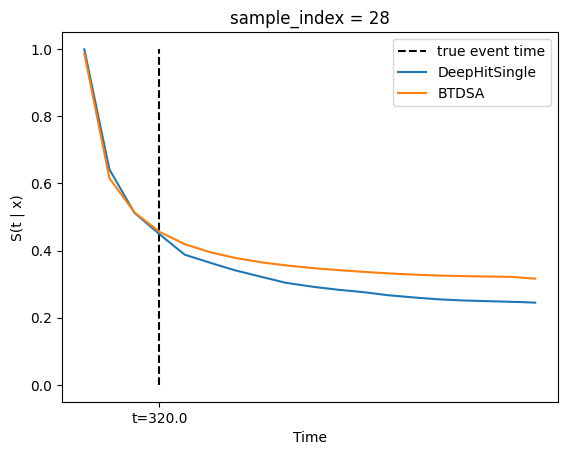

In [7]:
import random

sample_index = random.randint(0, 100)

for i, model_name in enumerate(model_list):
    surv, durations_test = infer_surv(model_name, dataset, time_range=time_range,
                                      group='uncensor', experiment_root='../tests')
    if i==0:
        plt.vlines(durations_test[sample_index], 0, 1, color='k', linestyles='--', label='true event time')
    plt.plot(surv.iloc[:, sample_index], label=model_name)
    
plt.xticks([durations_test[sample_index]], labels=[f't={durations_test[sample_index]}'])
plt.title(f"sample_index = {sample_index}")
plt.ylabel('S(t | x)')
plt.xlabel('Time')
plt.legend()

## Hazard Rates across time space

In [8]:
def hazard_rate_from_model_output(model_name, dataset, group='uncensor',
               time_range='full', experiment_root='../experiments'):
    
    cfg = setup_model_config(model_name, time_range, experiment_root=experiment_root)
    weight_file = cfg.model_save_dir / f"{cfg.model_name}_{cfg.time_range}_L{cfg.seq_len}_{dataset}.pth"
    trainer = init_trainer(cfg)
    model = trainer.load_model(weight_file)
    x_test, y_test = trainer.test
    
    labtrans = trainer.labtrans

    assert group in ['uncensor', 'censor']
    if group == 'uncensor':
        v = 1
    else:
        v = 0

    durations, events = y_test.T
    idxs = np.where(events==v)
    x_test = x_test[idxs]
    durations_test = durations[idxs]
    events_test = events[idxs]
        
    durations_idx, events = labtrans.transform(durations_test, events_test)
    hazard_rate = model.predict_pmf(x_test)
    return hazard_rate, durations_idx

[   0.        106.789474  213.57895   320.3684    427.1579    533.9474
  640.7368    747.5263    854.3158    961.1053   1067.8948   1174.6842
 1281.4736   1388.2632   1495.0526   1601.8422   1708.6316   1815.421
 1922.2106   2029.      ]
[   0.          106.78947368  213.57894737  320.36842105  427.15789474
  533.94736842  640.73684211  747.52631579  854.31578947  961.10526316
 1067.89473684 1174.68421053 1281.47368421 1388.26315789 1495.05263158
 1601.84210526 1708.63157895 1815.42105263 1922.21052632 2029.        ]


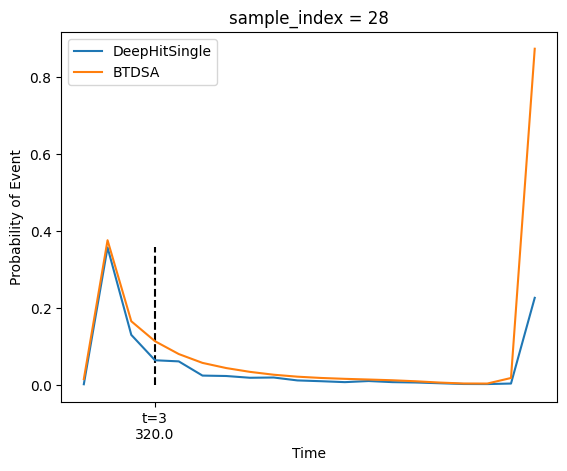

In [16]:
for i, model_name in enumerate(['DeepHitSingle', 'BTDSA']):
    surv, durations_test = infer_surv(model_name, dataset, 
                                      group='uncensor', experiment_root='../tests')
    surv = surv.iloc[:, sample_index]
    hazard_rate = surv.diff(-1).dropna()
    hazard_rate.index = surv.index[1:]
    
    if model_name in [ 'DeepHitSingle', 'DRSA', 'BTDSA']:
        hazard_rate, durations_idx = hazard_rate_from_model_output(model_name, dataset,
                                                   group='uncensor', experiment_root='../experiments')
        hazard_rate = hazard_rate[sample_index]
        true_event_time_index = durations_idx[sample_index]
    
    if i==0:
        plt.vlines(true_event_time_index, 0, hazard_rate.max(), color='k', linestyles='--')
    plt.plot(hazard_rate, label=model_name)
plt.xticks([true_event_time_index], labels=[f't={true_event_time_index}\n{durations_test[sample_index]}'])
plt.title(f"sample_index = {sample_index}")
plt.ylabel('Probability of Event')
plt.xlabel('Time')
#plt.ylim(0, 0.003)
plt.legend()